In [6]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML models
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

import warnings
warnings.filterwarnings('ignore')


In [7]:
# Load dataset
df = pd.read_csv("../data/listings.csv")

# Shape and preview
print("Shape:", df.shape)
df.head()


Shape: (459, 79)


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2992450,https://www.airbnb.com/rooms/2992450,20250804133828,2025-08-04,city scrape,Luxury 2 bedroom apartment,The apartment is located in a quiet neighborho...,NaN,https://a0.muscache.com/pictures/44627226/0e72...,4621559,...,4.56,3.22,3.67,NaN,f,1,1,0,0,0.07
1,3820211,https://www.airbnb.com/rooms/3820211,20250804133828,2025-08-04,city scrape,Funky Urban Gem: Prime Central Location - Park...,Step into the charming and comfy 1BR/1BA apart...,Overview<br /><br />The lovely apartment is lo...,https://a0.muscache.com/pictures/prohost-api/H...,19648678,...,4.81,4.81,4.77,NaN,f,4,4,0,0,2.32
2,5651579,https://www.airbnb.com/rooms/5651579,20250804133828,2025-08-04,city scrape,Large studio apt by Capital Center & ESP@,"Spacious studio with hardwood floors, fully eq...",The neighborhood is very eclectic. We have a v...,https://a0.muscache.com/pictures/b3fc42f3-6e5e...,29288920,...,4.88,4.76,4.64,NaN,f,2,1,1,0,2.97
3,6623339,https://www.airbnb.com/rooms/6623339,20250804133828,2025-08-04,city scrape,Bright & Cozy City Stay · Top Location + Parking!,Step into the charming and comfy 1BR/1BA apart...,Overview<br /><br />The lovely apartment is lo...,https://a0.muscache.com/pictures/prohost-api/H...,19648678,...,4.70,4.80,4.72,NaN,f,4,4,0,0,2.68
4,9005989,https://www.airbnb.com/rooms/9005989,20250804133828,2025-08-04,city scrape,"Studio in The heart of Center SQ, in Albany NY",(21 years of age or older ONLY) NON- SMOKING.....,"There are many shops, restaurants, bars, museu...",https://a0.muscache.com/pictures/d242a77e-437c...,17766924,...,4.93,4.87,4.77,NaN,f,1,1,0,0,5.67


In [8]:
# Basic info
df.info()

# Missing values
df.isnull().sum().sort_values(ascending=False).head(10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459 entries, 0 to 458
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            459 non-null    int64  
 1   listing_url                                   459 non-null    object 
 2   scrape_id                                     459 non-null    int64  
 3   last_scraped                                  459 non-null    object 
 4   source                                        459 non-null    object 
 5   name                                          459 non-null    object 
 6   description                                   449 non-null    object 
 7   neighborhood_overview                         196 non-null    object 
 8   picture_url                                   459 non-null    object 
 9   host_id                                       459 non-null    int

license                         459
calendar_updated                459
neighbourhood_group_cleansed    459
neighbourhood                   263
neighborhood_overview           263
host_about                      208
host_location                   114
host_neighbourhood               70
last_review                      68
first_review                     68
dtype: int64

In [9]:
# Handle missing values (simple example)
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
df = df.dropna(subset=['price', 'latitude', 'longitude'])

# Fill other missing columns appropriately
df.fillna({'reviews_per_month': 0}, inplace=True)


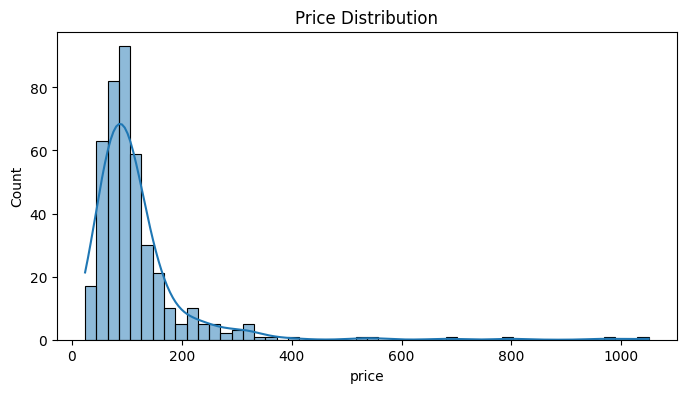

In [10]:
# Distribution of price
plt.figure(figsize=(8,4))
sns.histplot(df['price'], bins=50, kde=True)
plt.title("Price Distribution")
plt.savefig("../figures/price_distribution.png")
plt.show()


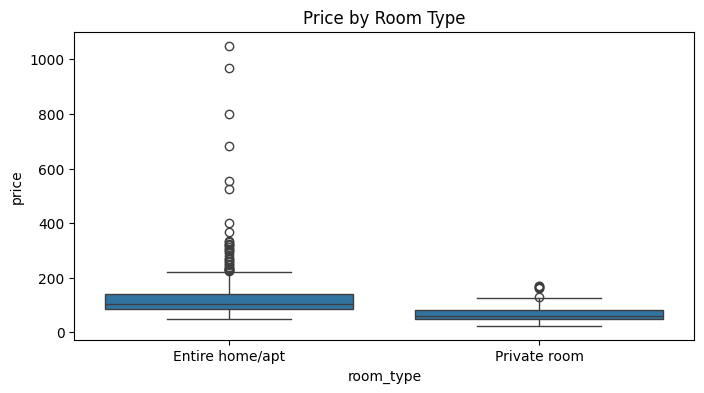

In [11]:
# Boxplot by room type
plt.figure(figsize=(8,4))
sns.boxplot(x='room_type', y='price', data=df)
plt.title("Price by Room Type")
plt.savefig("../figures/boxplot_roomtype.png")
plt.show()


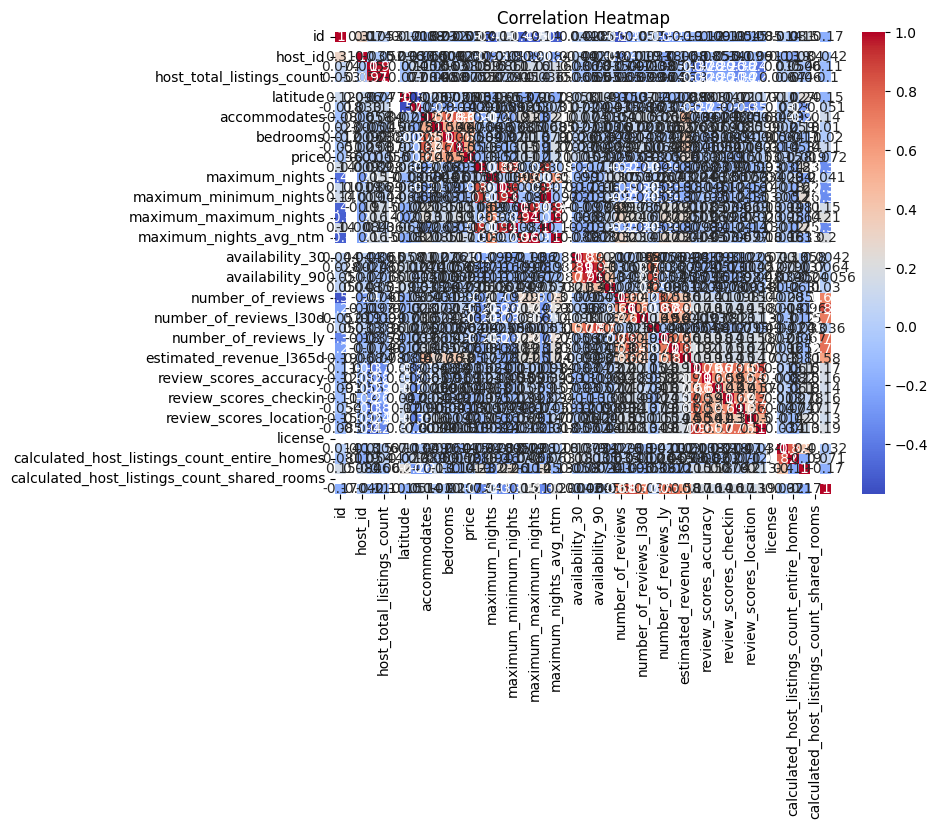

In [12]:
# Correlation heatmap
num_cols = df.select_dtypes(include=np.number)
plt.figure(figsize=(8,6))
sns.heatmap(num_cols.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.savefig("../figures/correlation_heatmap.png")
plt.show()


In [13]:
import datetime as dt

# Example features
df['num_amenities'] = df['amenities'].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)
df['host_since'] = pd.to_datetime(df['host_since'], errors='coerce')
df['host_tenure_days'] = (pd.Timestamp('2025-08-01') - df['host_since']).dt.days
df['description_length'] = df['description'].apply(lambda x: len(str(x).split()))

# Distance from city center (approx Albany lat/long)
albany_center = (42.6526, -73.7562)
df['distance_from_center'] = np.sqrt(
    (df['latitude'] - albany_center[0])**2 + (df['longitude'] - albany_center[1])**2
)

# Drop unused columns
features = ['num_amenities', 'host_tenure_days', 'description_length', 
            'distance_from_center', 'latitude', 'longitude', 'room_type']

df_model = df[features + ['price', 'number_of_reviews']]
df_model = df_model.dropna()


In [14]:
# Split data
X = df_model.drop(['price', 'number_of_reviews'], axis=1)
y = df_model['price']

# Identify categorical columns
cat_cols = ['room_type']
num_cols = X.columns.difference(cat_cols)

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# Models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}

# Evaluate models
results = {}
for name, model in models.items():
    pipe = Pipeline([('preprocess', preprocessor), ('model', model)])
    pipe.fit(X, y)
    preds = pipe.predict(X)
    results[name] = {
        "MAE": mean_absolute_error(y, preds),
        "RMSE": np.sqrt(mean_squared_error(y, preds)),
        "R2": r2_score(y, preds)
    }

pd.DataFrame(results).T


,MAE,RMSE,R2
Linear Regression,48.318107,90.459943,0.189812
Random Forest,16.293317,34.776845,0.880256
XGBoost,0.596230,0.878587,0.999924


In [15]:
# Define binary target
median_reviews = df_model['number_of_reviews'].median()
df_model['popular'] = (df_model['number_of_reviews'] > median_reviews).astype(int)

X = df_model.drop(['price', 'number_of_reviews', 'popular'], axis=1)
y = df_model['popular']

# Reuse preprocessor
models_cls = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42)
}

for name, model in models_cls.items():
    pipe = Pipeline([('preprocess', preprocessor), ('model', model)])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    print(f"\nModel: {name}")
    print(classification_report(y_test, preds))



Model: Random Forest
              precision    recall  f1-score   support

           0       0.79      0.81      0.80        42
           1       0.80      0.79      0.80        42

    accuracy                           0.80        84
   macro avg       0.80      0.80      0.80        84
weighted avg       0.80      0.80      0.80        84


Model: XGBoost
              precision    recall  f1-score   support

           0       0.81      0.81      0.81        42
           1       0.81      0.81      0.81        42

    accuracy                           0.81        84
   macro avg       0.81      0.81      0.81        84
weighted avg       0.81      0.81      0.81        84



In [16]:
# Save results
results_df = pd.DataFrame(results).T
results_df.to_csv("../figures/model_results.csv")
